In [2]:
import numpy as np
import seaborn as sns
import sklearn as sk
import scipy as sp
sns.set_style('white')
sns.set_context('notebook', font_scale=2)
sns.set()

import import_ipynb

import matplotlib.pyplot as pl

from pandas import read_csv

1. import data set
2. clean data set 
3. fit model to data
4. posterior predictive check 
5. Correlating to Clinical Measures

### 1. Import Data set 

In [3]:
data = read_csv("data.csv")

### 2. Clean data set 

#### Reindex participant ids

In [4]:
id_to_index = {}
i = 0

for name in data['subject'].unique():
    id_to_index[name] = i
    i += 1

data['subject'] = data['subject'].apply(lambda x: id_to_index[x])

num_participants = i

In [5]:
## DO NOT CHANGE THE CODE BELOW. If you do, you must go and change all HARDCODED_COLUMN_NUMBERS below 
data = data.drop(columns = ['task_version', 'screen_resolution', 'browser_interactions', 'key_press']);

In [6]:
data.head()

,subject,block,trial,exposure,context,probability,card_position,card_color,card_suit,card_points,certain_points,choice,rt,outcome,prev_outcome,quintiles
0,0,2,51,1,0.0,0.2,0,#ae4862,gecko-reptile-shape,0,8,0.0,1.524,8,NaN,1
1,0,2,52,2,0.0,0.2,1,#ae4862,gecko-reptile-shape,10,5,0.0,1.480,5,0.0,1
2,0,2,55,3,0.0,0.2,0,#ae4862,gecko-reptile-shape,0,10,0.0,0.877,10,1.0,1
3,0,2,56,4,0.0,0.2,1,#ae4862,gecko-reptile-shape,0,6,0.0,2.080,6,0.0,1
4,0,2,58,5,0.0,0.2,1,#ae4862,gecko-reptile-shape,0,2,0.0,1.127,2,0.0,1


### 3. Fit model to data 

In [7]:
num_blocks = 6;
trials_per_block = 25; 

SURE_POINTS_COL = 10;
REWARD_COL = 13;
CHOICE_COL = 11; 

In [8]:
# fill arrays with the following info for each participant 
sure_values = np.ndarray([num_participants, num_blocks * trials_per_block])
rewards = np.ndarray([num_participants, num_blocks * trials_per_block])
choices = np.ndarray([num_participants, num_blocks * trials_per_block], dtype="int8")

for p in range(0, num_participants):
    for b in range(0, num_blocks): 
        for t in range(0, trials_per_block):
            
            participant_i = (b*trials_per_block) + t # overall trial number for current participant
            i = (p *(num_blocks * trials_per_block)) +  participant_i # index into row in df
            
            sure_val = data.iloc[i, SURE_POINTS_COL]
            reward_val = data.iloc[i, REWARD_COL]
            choice_val = data.iloc[i, CHOICE_COL]
            
            sure_values[p, participant_i] = sure_val
            rewards[p, participant_i] = reward_val
            choices[p, participant_i] = choice_val

In [9]:
fits = np.ndarray([num_participants, 3]) # beta, pos_eta, neg_eta for each participant

#### Transformed parameter fits (stored in pfit_t)

In [105]:
from stantools.io import load_model

## Compile model.
StanModel = load_model('tqbnorm_util_stan_real')

pfit_t = [dict() for x in range(num_participants)] # model output parameters for each participant 

# run model fit for each participant 
for p in range(0, num_participants):
    pt = 0 # stan print debugging option

    ## Prepare data for Stan.
    dd = dict( T = trials_per_block, B = num_blocks, Y = choices[p,:], R = rewards[p,:],S = sure_values[p,:], p = pt, q0_scale = 10, q0_shift = 0)

    ## Fit model.
    s = 0; 
    #print(p)
    StanFit = StanModel.optimizing(data=dd, seed=s, tol_param = 1e-3)
    for i in ['beta', 'pos_eta', 'neg_eta', 'q0', 'alpha']:
        temp = StanFit[i]
        pfit_t[p][i] = temp[()]

In [107]:
beta = np.zeros(num_participants)
pos_eta = np.zeros(num_participants)
neg_eta = np.zeros(num_participants)
risk_ratio = np.zeros(num_participants)
q_init = np.zeros(num_participants)
alpha = np.zeros(num_participants)

using_transform = 1 # using transformed fit or not? 

for i in range(0, num_participants):
    if(using_transform): 
        beta[i] = pfit_t[i]['beta']
        pos_eta[i] = pfit_t[i]['pos_eta']
        neg_eta[i] = pfit_t[i]['neg_eta']
        q_init[i] = pfit_t[i]['q0']
        alpha[i] = pfit_t[i]['alpha']
        risk_ratio[i] = (pos_eta[i] - neg_eta[i])/(pos_eta[i] + neg_eta[i])
    else: 
        beta[i] = pfit[i]['beta']
        pos_eta[i] = pfit[i]['pos_eta']
        neg_eta[i] = pfit[i]['neg_eta']
        risk_ratio[i] = (pos_eta[i] - neg_eta[i])/(pos_eta[i] + neg_eta[i])

##### Figures for model fit parameters

In [108]:
print("Mean / Median / Min / Max / Std Dev for: pos eta")
print(np.mean(pos_eta))
print(np.median(pos_eta))
print(np.min(pos_eta))
print(np.max(pos_eta))
print(np.std(pos_eta))

print("Mean / Median / Min / Max / Std Dev for: neg eta")
print(np.mean(neg_eta))
print(np.median(neg_eta))
print(np.min(neg_eta))
print(np.max(neg_eta))
print(np.std(neg_eta))

print("Mean / Median / Min / Max / Std Dev for: beta")
print(np.mean(beta))
print(np.median(beta))
print(np.min(beta))
print(np.max(beta))
print(np.std(beta))

print("Mean / Median / Min / Max / Std Dev for: q0")
print(np.mean(q_init))
print(np.median(q_init))
print(np.min(q_init))
print(np.max(q_init))
print(np.std(q_init))

print("Mean / Median / Min / Max / Std Dev for: RR")
print(np.mean(risk_ratio))
print(np.median(risk_ratio))
print(np.min(risk_ratio))
print(np.max(risk_ratio))
print(np.std(risk_ratio))

print("Mean / Median / Min / Max / Std Dev for: alpha")
print(np.mean(alpha))
print(np.median(alpha))
print(np.min(alpha))
print(np.max(alpha))
print(np.std(alpha))

Mean / Median / Min / Max / Std Dev for: pos eta
0.0899102491958046
0.07408663076400437
0.0050681709323360125
0.4917663403707582
0.0676266758032756
Mean / Median / Min / Max / Std Dev for: neg eta
0.12735448800923266
0.11788762689876155
0.009892590505360751
0.8524148113333015
0.12364217267237602
Mean / Median / Min / Max / Std Dev for: beta
0.49833545099521664
0.4274279185225871
0.07986576296576577
1.3927700313175204
0.30073967443390515
Mean / Median / Min / Max / Std Dev for: q0
5.15235282919604
5.1896572099572795
1.8693630176713658
9.70496697028822
1.3836820605710445
Mean / Median / Min / Max / Std Dev for: RR
-0.11148475533540055
-0.10982648940961995
-0.7557352753263834
0.4619905529339713
0.2640636734517861
Mean / Median / Min / Max / Std Dev for: alpha
1.328250248054696
1.327378220660492
0.5286159804003374
1.8327621465939556
0.2756667644240211


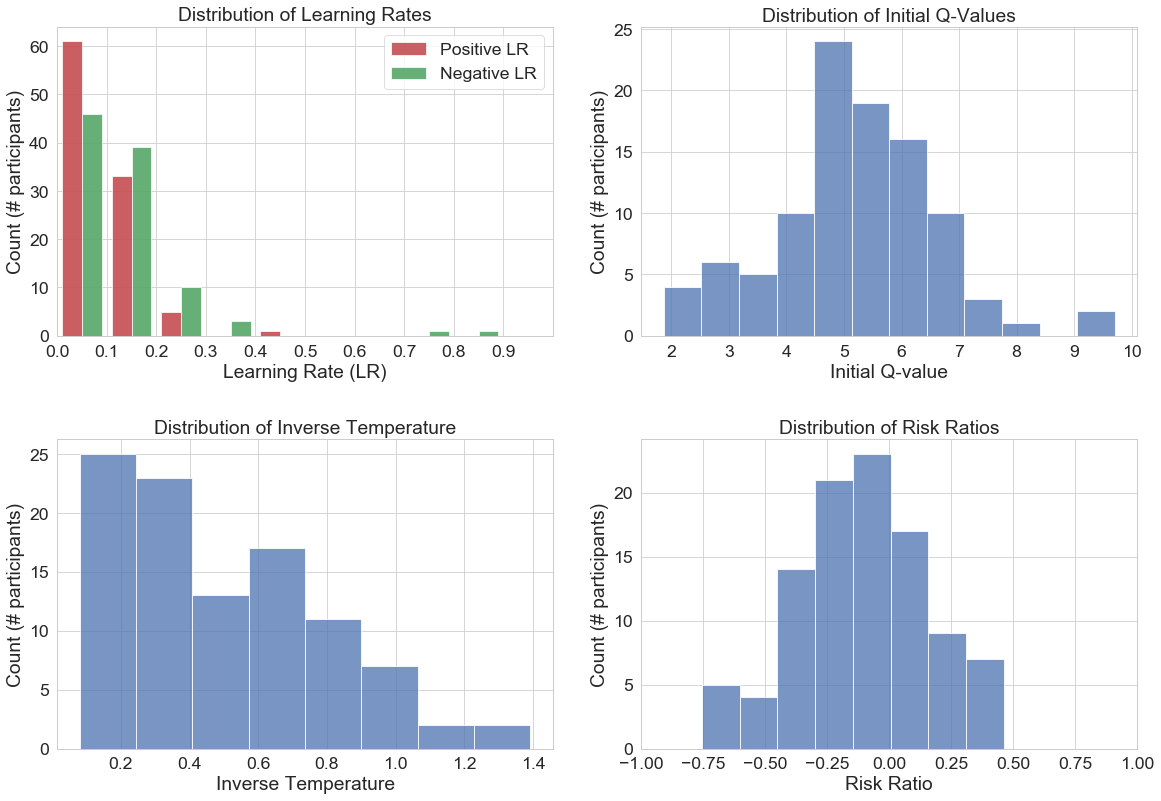

In [99]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2)

fig, axs = pl.subplots(2, 2, gridspec_kw={'height_ratios': [1, 1]}, figsize=(17,12))
axs[0, 0].hist([pos_eta, neg_eta], color=['r','g'], label = ["Positive LR", "Negative LR"], alpha=0.9, bins=np.arange(0, 1, 0.1))
axs[0, 0].legend()
axs[0, 0].set_title("Distribution of Learning Rates")
axs[0, 0].set_xlim(0, 1)
axs[0, 0].set_xticks(np.arange(0, 1, 0.1))
axs[0, 0].set_xlabel("Learning Rate (LR)")
axs[0, 0].set_ylabel("Count (# participants)")

sns.histplot(q_init, ax = axs[0, 1])
axs[0, 1].set_title("Distribution of Initial Q-Values")
axs[0, 1].set_xlabel("Initial Q-value")
axs[0, 1].set_ylabel("Count (# participants)")

sns.histplot(beta, ax = axs[1,0])
axs[1,0].set_title("Distribution of Inverse Temperature")
axs[1,0].set_xlabel("Inverse Temperature")
axs[1,0].set_ylabel("Count (# participants)")

sns.histplot(risk_ratio, bins = 8,ax = axs[1,1])
axs[1,1].set_xlim(-1, 1)
axs[1,1].set_title("Distribution of Risk Ratios")
axs[1,1].set_xlabel("Risk Ratio")
axs[1,1].set_ylabel("Count (# participants)")

pl.tight_layout(pad=2.0)
pl.savefig('C.png', dpi = 300)

Text(0, 0.5, 'Count (# participants)')

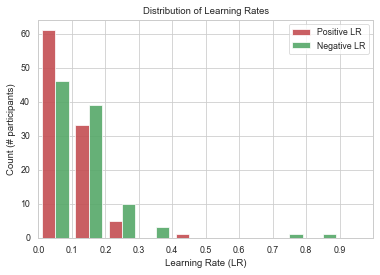

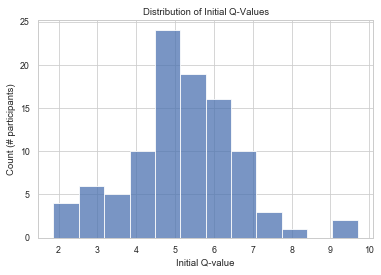

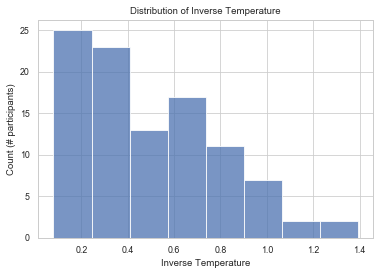

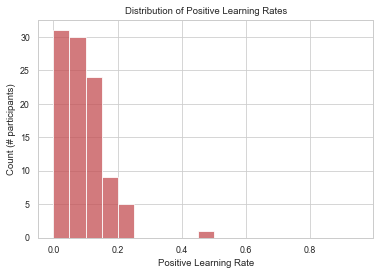

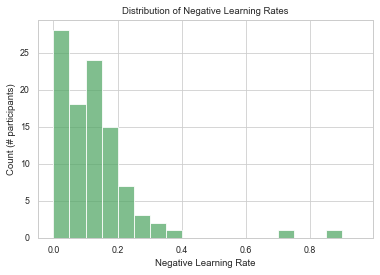

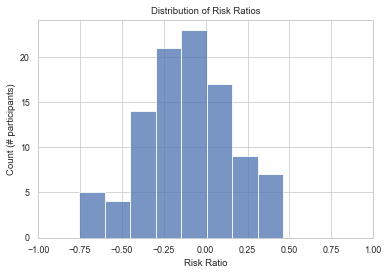

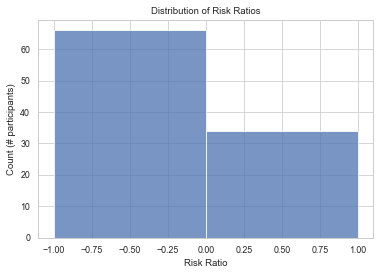

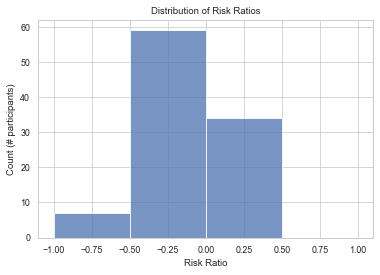

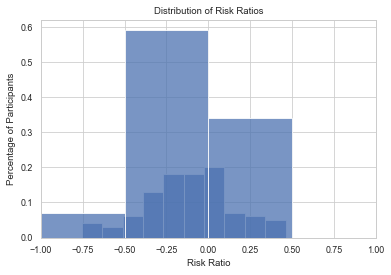

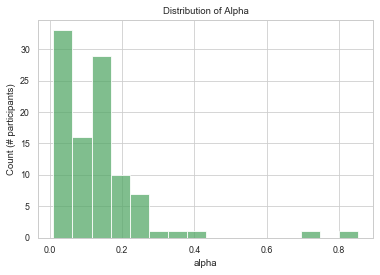

In [109]:
sns.set_style("whitegrid")
sns.set_context("paper")

pl.hist([pos_eta, neg_eta], color=['r','g'], label = ["Positive LR", "Negative LR"], alpha=0.9, bins=np.arange(0, 1, 0.1))
pl.legend()
pl.title("Distribution of Learning Rates")
pl.xlim(0, 1)
pl.xticks(np.arange(0, 1, 0.1))
pl.xlabel("Learning Rate (LR)")
pl.ylabel("Count (# participants)")

pl.figure()
sns.histplot(q_init)
pl.title("Distribution of Initial Q-Values")
pl.xlabel("Initial Q-value")
pl.ylabel("Count (# participants)")

pl.figure()
sns.histplot(beta)
pl.title("Distribution of Inverse Temperature")
pl.xlabel("Inverse Temperature")
pl.ylabel("Count (# participants)")

pl.figure()
sns.histplot(pos_eta, bins=np.arange(0, 1, 0.05), color = 'r')
pl.title("Distribution of Positive Learning Rates")
pl.xlabel("Positive Learning Rate")
pl.ylabel("Count (# participants)")

pl.figure()
sns.histplot(neg_eta, bins=np.arange(0, 1, 0.05), color = 'g')
pl.title("Distribution of Negative Learning Rates")
pl.xlabel("Negative Learning Rate")
pl.ylabel("Count (# participants)")

pl.figure()
sns.histplot(risk_ratio, bins = 8)
pl.xlim(-1, 1)
pl.title("Distribution of Risk Ratios")
pl.xlabel("Risk Ratio")
pl.ylabel("Count (# participants)")

pl.figure()
sns.histplot(risk_ratio, bins = np.array([-1, 0, 1]))
pl.title("Distribution of Risk Ratios")
pl.xlabel("Risk Ratio")
pl.ylabel("Count (# participants)")

pl.figure()
sns.histplot(risk_ratio, bins = np.array([-1, -0.5, 0, 0.5, 1]))
pl.title("Distribution of Risk Ratios")
pl.xlabel("Risk Ratio")
pl.ylabel("Count (# participants)")

pl.figure()
sns.histplot(risk_ratio, stat = "probability")
pl.xlim(-1, 1)
pl.title("Distribution of Risk Ratios")
pl.xlabel("Risk Ratio")
pl.ylabel("Count (# participants)")

sns.histplot(risk_ratio, bins = np.array([-1, -0.5, 0, 0.5, 1]), stat = "probability")
pl.title("Distribution of Risk Ratios")
pl.xlabel("Risk Ratio")
pl.ylabel("Percentage of Participants")

pl.figure()
sns.histplot(neg_eta, color = 'g')
pl.title("Distribution of Alpha")
pl.xlabel("alpha")
pl.ylabel("Count (# participants)")


### 4.Posterior Predictive Check

In [100]:
def inv_logit(dif, beta):
    """Logistic choice rule."""
    return 1. / (1 + np.exp(beta * -dif))

In [101]:
y_hat = np.ndarray([num_participants, num_blocks * trials_per_block], dtype="int8")
y_pred = np.ndarray([num_participants, num_blocks * trials_per_block])
theta_hat_a = np.ndarray([num_participants, num_blocks * trials_per_block])

for p in range (0, num_participants):
    for b in range(0, num_blocks):
        Q = pfit_t[p]['q0']
        for t in range(0, trials_per_block):

            participant_i = (b*trials_per_block) + t; # overall trial number for current participant

            sure_points = sure_values[p, participant_i];
            reward = rewards[p, participant_i];
            y_true = choices[p, participant_i]; 

            theta_hat = inv_logit(Q - sure_points, pfit_t[p]['beta'])
            theta_hat_a[p, participant_i] = theta_hat; 

            y_hat[p, participant_i] = np.random.binomial(1, theta_hat)

            if(y_true == 1):
                y_pred[p, participant_i] = theta_hat;
            if(y_true == 0):
                y_pred[p, participant_i] = 1-theta_hat;

            delta = reward - Q; 
            if(delta < 0): Q += pfit_t[p]['neg_eta'] * delta 
            if(delta >= 0): Q += pfit_t[p]['pos_eta'] * delta   
                
y_hat_means = np.zeros(num_participants)
y_real_means = np.zeros(num_participants)
theta_hat_means = np.zeros(num_participants)

for i in range(0, num_participants): y_hat_means[i] = y_hat[i,:].mean()
for i in range(0, num_participants): y_real_means[i] = choices[i,:].mean()
for i in range(0, num_participants): theta_hat_means[i] = theta_hat_a[i,:].mean()
    
y_flat = y_pred.flatten()

##### Figures for Posterior Predictive Check

Text(0.5, 1.0, 'Distribution of Y_pred values for All Participants')

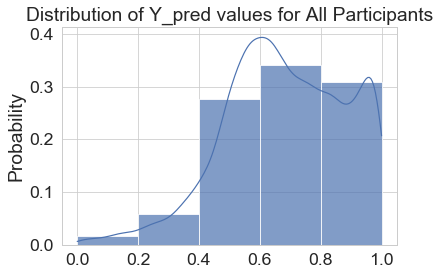

In [102]:
pl.figure()
sns.histplot(y_flat, bins = 5, kde = True, alpha = 0.7, stat = "probability")
pl.title("Distribution of Y_pred values for All Participants")

Pearson r:  0.7967009064949644
% Y Hat greater than actual choices:  0.55


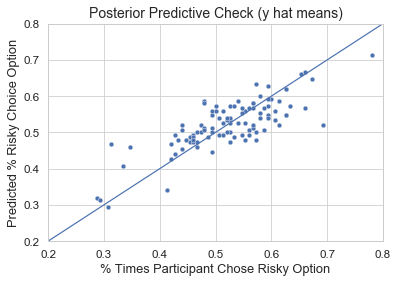

In [103]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale = 1.33)

pl.xlim(0.2, 0.8)
pl.ylim(0.2, 0.8)

#sns.regplot(x= y_real_means, y = y_hat_means, truncate = False, marker = '.', ci = 95)
sns.scatterplot(x= y_real_means, y = y_hat_means, marker = 'o')
line = {0:0, 0.1:0.1, 0.5: 0.5, 0.9:0.9}
pl.plot(list(line.keys()), list(line.values()))
pl.title("Posterior Predictive Check (y hat means)", fontsize = 14)
pl.xlabel("% Times Participant Chose Risky Option")#, fontsize = 11)
pl.ylabel("Predicted % Risky Choice Option")#, fontsize = 11)
r = sp.stats.pearsonr(y_real_means, y_hat_means)[0]
print("Pearson r: ", r)

pl.savefig('D.png', dpi = 300)

greater = 0; 
for i in range(0, num_participants):
    if(y_hat_means[i] > y_real_means[i]): greater+=1;
        
print("% Y Hat greater than actual choices: ", greater/num_participants)

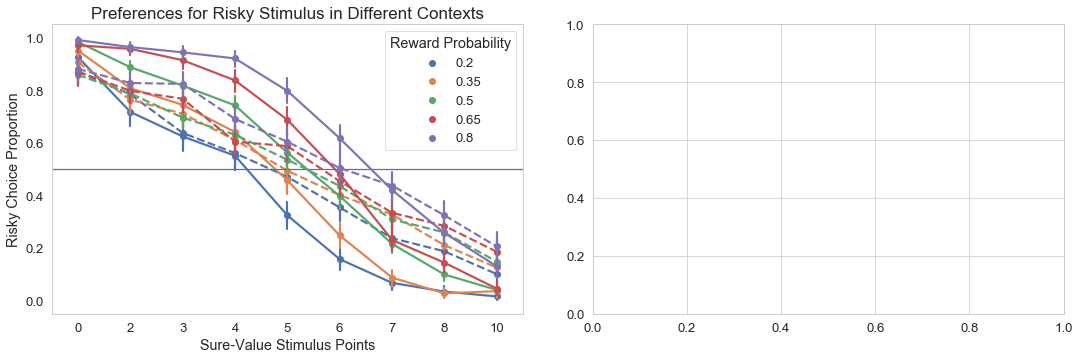

In [104]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale = 1.5)
fig, axs = pl.subplots(1,2, figsize=(16, 6))

data['y_hat_choice'] = y_hat.flatten()
sns.pointplot(x = "certain_points", y = "choice", hue = "probability", data=data, ax = axs[0], label='_nolegend_')
sns.pointplot(x = "certain_points", y = "y_hat_choice",hue = "probability", data=data, ax = axs[0], linestyles = "--")
axs[0].axhline(0.5)
axs[0].set_xlabel("Sure-Value Stimulus Points")
axs[0].set_ylabel("Risky Choice Proportion")
axs[0].set_title("Preferences for Risky Stimulus in Different Contexts", fontsize = 17);
axs[0].grid(False)

handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles[5:], labels[5:], title="Reward Probability")

pl.tight_layout(pad=3.0)
pl.savefig('PPC.png', dpi = 300)


In [ ]:
x = np.arange(0, 11)
pl.plot(x, x-5)
pl.plot(x, np.sign(x-5)**2)

Pearson r:  0.9878583159294116
% Theta Hat greater than actual choices:  0.87
% Participants q0 greater than 5.5:  0.34
% Participants q0 less than 4.5:  0.28


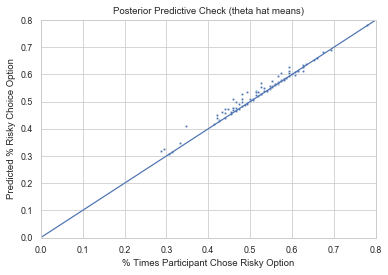

In [18]:
sns.set_style("whitegrid")
sns.set_context("paper")

pl.ylim(0, 0.8)
pl.xlim(0, 0.8)

#sns.regplot(x= y_real_means, y = theta_hat_means, truncate = False, marker = '.', ci = 95)

sns.scatterplot(x= y_real_means, y = theta_hat_means, marker = '.')
line = {0:0, 0.1:0.1, 0.5: 0.5, 0.9:0.9}
pl.plot(list(line.keys()), list(line.values()))
pl.title("Posterior Predictive Check (theta hat means)")
pl.xlabel("% Times Participant Chose Risky Option")
pl.ylabel("Predicted % Risky Choice Option")
r = sp.stats.pearsonr(y_real_means, theta_hat_means)[0]
print("Pearson r: ", r)

pl.savefig('E.png', dpi = 300)

greater = 0; 
q_greater = 0;
q_less = 0;
for i in range(0, num_participants):
    if(theta_hat_means[i] > y_real_means[i]): greater+=1;
    if(pfit_t[i]['q0'] > 5.5): q_greater+=1;
    if(pfit_t[i]['q0'] < 4.5): q_less +=1
        
print("% Theta Hat greater than actual choices: ", greater/num_participants)
print("% Participants q0 greater than 5.5: ", q_greater/num_participants)
print("% Participants q0 less than 4.5: ", q_less/num_participants)

### 5. Correlating to Clinical Measures

In [19]:
scores = read_csv("scores.csv")

id_to_index = {}
i = 0

for name in scores['subject'].unique():
    id_to_index[name] = i
    i += 1

scores['subject'] = scores['subject'].apply(lambda x: id_to_index[x])

num_participants = i

scores = scores.drop(columns = ['task_version'])

scores['beta'] = beta
scores['pos_eta'] = pos_eta
scores['neg_eta'] = neg_eta
scores['risk ratio'] = risk_ratio
scores['choices'] = y_real_means
scores['q0'] = [d['q0'] for d in pfit_t]

scores

,subject,grq,gad7,pswq,ius12,beta,pos_eta,neg_eta,risk ratio,choices,q0
0,0,2,6,20,33,1.061007,0.085069,0.128801,-0.204480,0.506667,3.890169
1,1,6,7,15,20,0.866555,0.212877,0.181367,0.079926,0.660000,6.290633
2,2,7,12,25,32,0.731019,0.127817,0.207131,-0.236795,0.473333,3.876795
3,3,2,20,31,42,0.570694,0.224946,0.376105,-0.251491,0.440000,1.604751
4,4,9,5,16,6,0.740994,0.057309,0.116925,-0.342159,0.433333,5.036696
...,...,...,...,...,...,...,...,...,...,...,...
95,95,3,2,5,24,1.739887,0.007575,0.042374,-0.696706,0.466667,4.930640
96,96,4,5,17,14,1.373874,0.028995,0.061955,-0.362403,0.440000,4.037085
97,97,7,3,8,15,0.504327,0.167085,0.164947,0.006440,0.560000,4.878646
98,98,4,5,7,16,1.885738,0.034582,0.042177,-0.098949,0.526667,4.859171


In [20]:
scores.corr(method='spearman')

,subject,grq,gad7,pswq,ius12,beta,pos_eta,neg_eta,risk ratio,choices,q0
subject,1.000000,-0.003587,-0.169662,-0.102871,-0.065164,0.082280,-0.207225,-0.133297,-0.056142,0.031520,0.070171
grq,-0.003587,1.000000,-0.050372,-0.278715,-0.487478,-0.088384,-0.048805,-0.076136,-0.000303,-0.005544,0.044987
gad7,-0.169662,-0.050372,1.000000,0.700879,0.388435,-0.138756,0.040905,0.007286,0.076390,-0.021661,-0.053113
pswq,-0.102871,-0.278715,0.700879,1.000000,0.531398,-0.103598,0.044567,0.071038,0.028879,-0.033175,-0.157109
ius12,-0.065164,-0.487478,0.388435,0.531398,1.000000,-0.074795,0.108468,0.079224,0.071358,0.037306,-0.040588
beta,0.082280,-0.088384,-0.138756,-0.103598,-0.074795,1.000000,-0.686481,-0.650549,0.035872,0.187478,0.135422
pos_eta,-0.207225,-0.048805,0.040905,0.044567,0.108468,-0.686481,1.000000,0.763816,0.151875,0.129332,0.046073
neg_eta,-0.133297,-0.076136,0.007286,0.071038,0.079224,-0.650549,0.763816,1.000000,-0.453213,-0.313070,-0.084476
risk ratio,-0.056142,-0.000303,0.076390,0.028879,0.071358,0.035872,0.151875,-0.453213,1.000000,0.669913,0.171881
choices,0.031520,-0.005544,-0.021661,-0.033175,0.037306,0.187478,0.129332,-0.313070,0.669913,1.000000,0.712167


In [21]:
GAD7_COL = 2
gad7_cat = np.empty(num_participants, dtype='object') 

for p in range(num_participants):
    if(scores.iloc[p, GAD7_COL] <= 5): gad7_cat[p] = "None"
    elif(scores.iloc[p, GAD7_COL] <= 10): gad7_cat[p] = "Mild"
    elif(scores.iloc[p, GAD7_COL] <= 15): gad7_cat[p] = "Moderate"
    elif(scores.iloc[p, GAD7_COL] <= 21): gad7_cat[p] = "Severe"
    
scores['gad7_cat'] = gad7_cat

Means
6.83
16.12
21.32
5.33
Medians
6.0
16.5
19.5
6.0
Mins
0
0
4
0
Maxs
21
32
46
10
Std devs
5.01725306146982
8.073250506293837
8.642016225652695
2.169834514008342


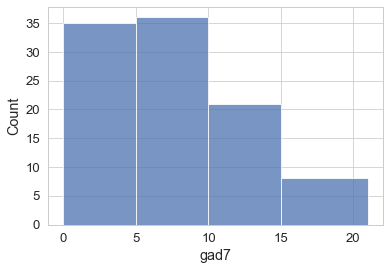

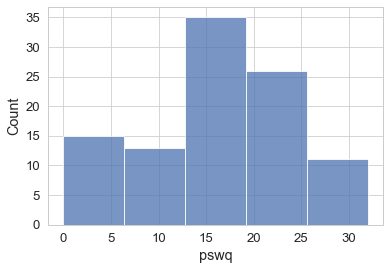

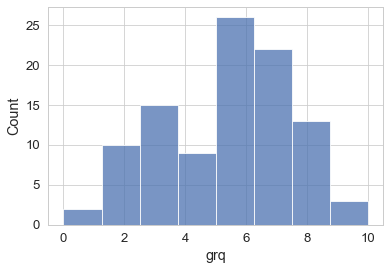

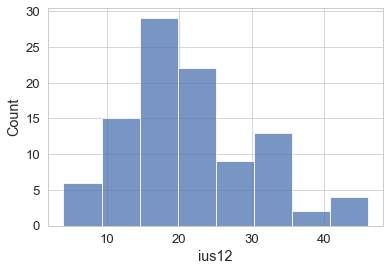

In [71]:
sns.histplot(data=scores, x= "gad7", bins = [0, 5, 10, 15, 21]); # [0, 21]
pl.figure()
sns.histplot(data=scores, x= "pswq", bins = 5) # [16-80]
pl.figure()
sns.histplot(data=scores, x= "grq") # [0-10]
pl.figure()
sns.histplot(data=scores, x= "ius12") # [12-60]

print("Means")
for q in ['gad7', 'pswq', 'ius12', 'grq']:
    print(scores[q].mean())

print("Medians")
for q in ['gad7', 'pswq', 'ius12', 'grq']:
    print(scores[q].median())

print("Mins")
for q in ['gad7', 'pswq', 'ius12', 'grq']:
    print(scores[q].min())

print("Maxs")
for q in ['gad7', 'pswq', 'ius12', 'grq']:
    print(scores[q].max())

print("Std devs")
for q in ['gad7', 'pswq', 'ius12', 'grq']:
    print(scores[q].std())



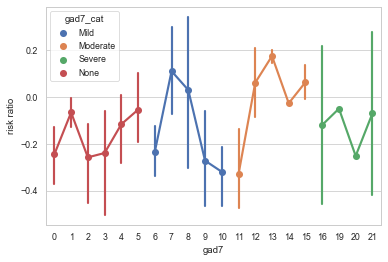

In [23]:
scores
sns.pointplot(x= 'gad7', y = 'risk ratio', hue = 'gad7_cat', data= scores)

Pearson R =  0.7221067908931769
Pearson p-value =  2.2891812914673863e-17


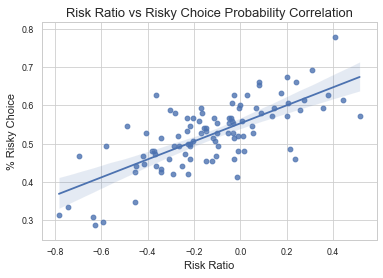

In [26]:
#spr = sp.stats.spearmanr(risk_ratio, scores['choices'])
pr = sp.stats.pearsonr(risk_ratio, scores['choices'])
#print("Spearman R = ", spr[0])
print("Pearson R = ", pr[0])
print("Pearson p-value = ", pr[1])
sns.regplot(data=scores, x= "risk ratio", y = "choices")
pl.title("Risk Ratio vs Risky Choice Probability Correlation", fontsize = 13)
pl.xlabel("Risk Ratio", fontsize = 11)
pl.ylabel("% Risky Choice", fontsize = 11)

pl.savefig('F.png', dpi = 300)

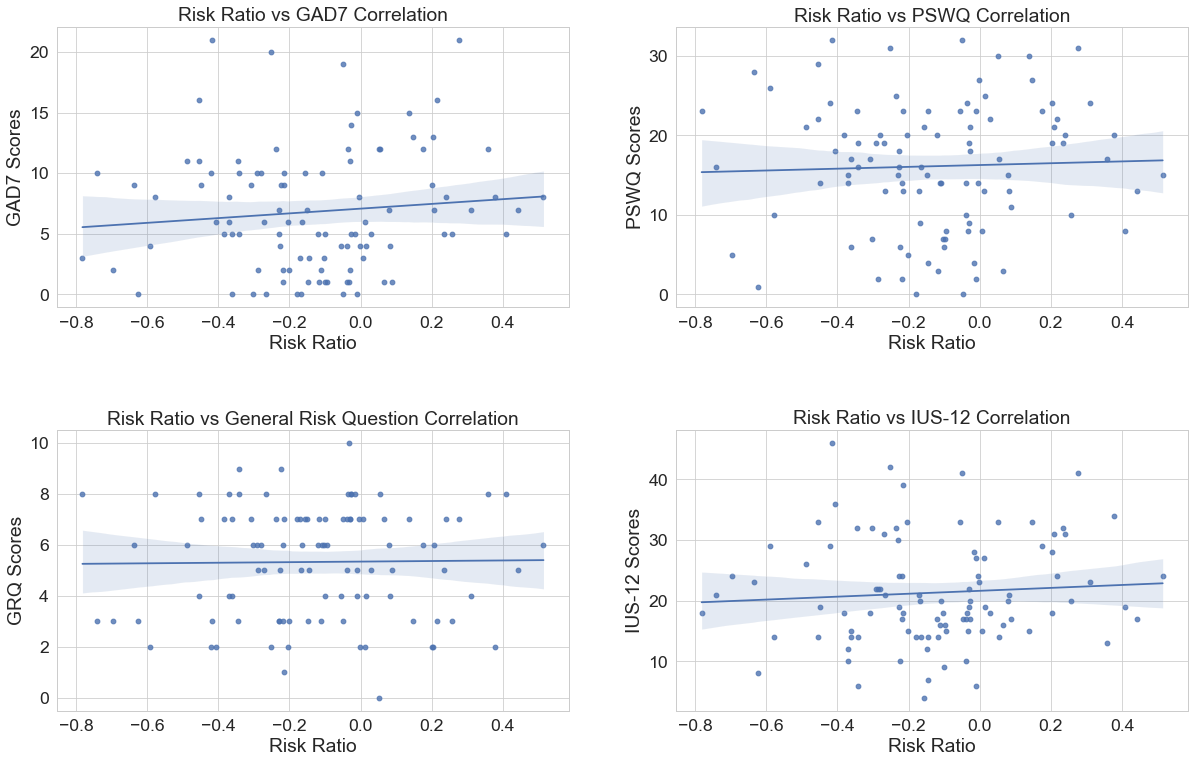

In [27]:
sns.set_context("paper", font_scale=2)

fig, axs = pl.subplots(2, 2, gridspec_kw={'height_ratios': [1, 1]}, figsize=(18,12))

sns.regplot(data=scores, y= "gad7", x = "risk ratio", ax = axs[0, 0])
axs[0, 0].set_title("Risk Ratio vs GAD7 Correlation") #, fontsize = 13)
axs[0, 0].set_xlabel("Risk Ratio" ) #, fontsize = 11)
axs[0, 0].set_ylabel("GAD7 Scores") #, fontsize = 11)

sns.regplot(data=scores, y= "pswq", x = "risk ratio", ax = axs[0, 1])
axs[0, 1].set_title("Risk Ratio vs PSWQ Correlation") #, fontsize = 13)
axs[0, 1].set_xlabel("Risk Ratio") #, fontsize = 11)
axs[0, 1].set_ylabel("PSWQ Scores") #, fontsize = 11)

sns.regplot(data=scores, y= "grq", x = "risk ratio", ax = axs[1, 0])
axs[1, 0].set_title("Risk Ratio vs General Risk Question Correlation") #, fontsize = 13)
axs[1, 0].set_xlabel("Risk Ratio") #, fontsize = 11)
axs[1, 0].set_ylabel("GRQ Scores") #, fontsize = 11)

sns.regplot(data=scores, y= "ius12", x = "risk ratio", ax = axs[1, 1])
axs[1, 1].set_title("Risk Ratio vs IUS-12 Correlation") #, fontsize = 13)
axs[1, 1].set_xlabel("Risk Ratio") #, fontsize = 11)
axs[1, 1].set_ylabel("IUS-12 Scores") #, fontsize = 11)

pl.tight_layout(pad=3.0)
pl.savefig('G.png', dpi = 300)

Spearman R =  0.07639019742142149
Spearman p-value =  0.45000746789491375


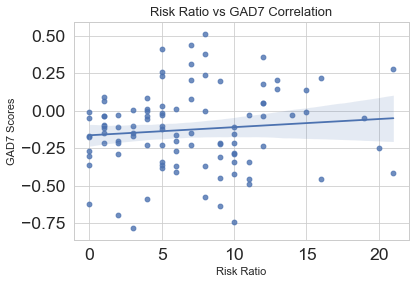

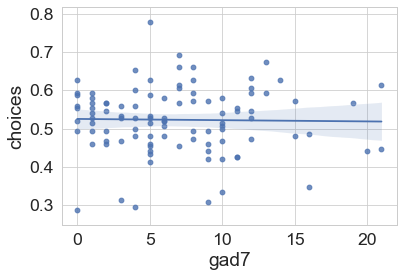

In [28]:
spr = sp.stats.spearmanr(risk_ratio, scores['gad7'])
print("Spearman R = ", spr[0])
print("Spearman p-value = ", spr[1])
sns.regplot(data=scores, x= "gad7", y = "risk ratio")
pl.title("Risk Ratio vs GAD7 Correlation", fontsize = 13)
pl.xlabel("Risk Ratio", fontsize = 11)
pl.ylabel("GAD7 Scores", fontsize = 11)
pl.figure()

sns.regplot(data=scores, x= "gad7", y = "choices")

Spearman R =  0.028878711475161464
Spearman p-value =  0.775478790287023


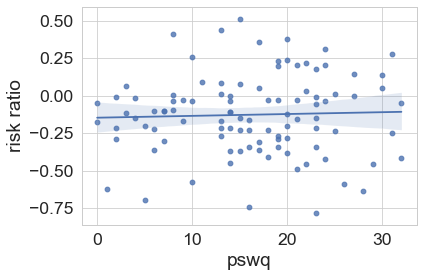

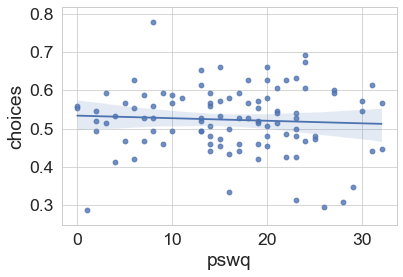

In [29]:
spr = sp.stats.spearmanr(risk_ratio, scores['pswq'])
print("Spearman R = ", spr[0])
print("Spearman p-value = ", spr[1])
sns.regplot(data=scores, x= "pswq", y = "risk ratio")
pl.figure()
sns.regplot(data=scores, x= "pswq", y = "choices")

Spearman R =  -0.0003034739844621693
Spearman p-value =  0.9976090744594575


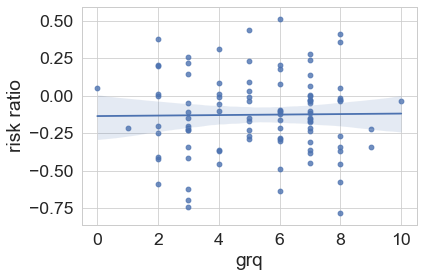

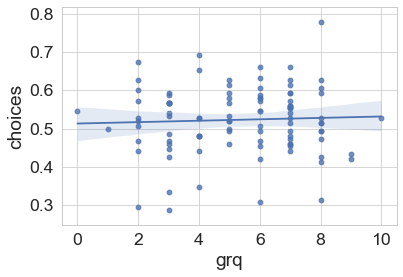

In [30]:
spr = sp.stats.spearmanr(risk_ratio, scores['grq'])
print("Spearman R = ", spr[0])
print("Spearman p-value = ", spr[1])
sns.regplot(data=scores, x= "grq", y = "risk ratio")
pl.figure()
sns.regplot(data=scores, x= "grq", y = "choices")

Spearman R =  0.07135846307433907
Spearman p-value =  0.48049090278993145


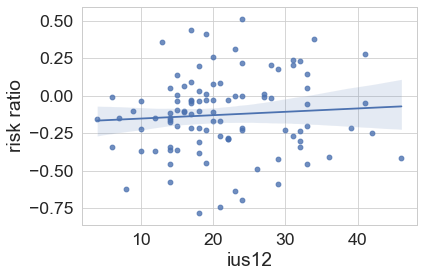

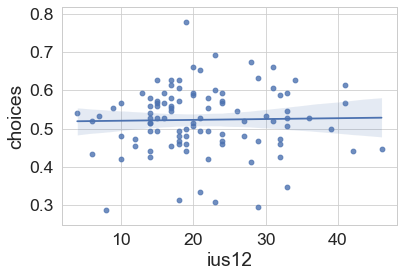

In [31]:
spr = sp.stats.spearmanr(risk_ratio, scores['ius12'])
print("Spearman R = ", spr[0])
print("Spearman p-value = ", spr[1])
sns.regplot(data=scores, x= "ius12", y = "risk ratio")
pl.figure()
sns.regplot(data=scores, x= "ius12", y = "choices")

In [93]:
corr = scores.corr(method = "spearman")
# As expected :)
    # gad7 + ius12 
    # gad7 + pswq 
    # ius12 + pswq
# Weird things:
    # grq neg corr with everything... 
    # grq - ius 12
    # gad7 slight + risk ratio (means higher anxiety -> risk seeking??)
    # gad7 slight - beta 
    # beta - pos and neg eta (magnitude effect)
    # beta + risk ratio (see beta values_real... lower should be more explore/higher exploit)
    # pos eta + ius12 
    # neg eta + ius12 
    # pos eta + neg eta (magnitude effect)
    # choices + pos_eta
    # choice - neg_eta 

corr.to_csv("correlations.csv")
corr

,subject,grq,gad7,pswq,ius12,beta,pos_eta,neg_eta,risk ratio,choices,q0
subject,1.000000,-0.003587,-0.169662,-0.102871,-0.065164,0.082280,-0.207225,-0.133297,-0.056142,0.031520,0.070171
grq,-0.003587,1.000000,-0.050372,-0.278715,-0.487478,-0.088384,-0.048805,-0.076136,-0.000303,-0.005544,0.044987
gad7,-0.169662,-0.050372,1.000000,0.700879,0.388435,-0.138756,0.040905,0.007286,0.076390,-0.021661,-0.053113
pswq,-0.102871,-0.278715,0.700879,1.000000,0.531398,-0.103598,0.044567,0.071038,0.028879,-0.033175,-0.157109
ius12,-0.065164,-0.487478,0.388435,0.531398,1.000000,-0.074795,0.108468,0.079224,0.071358,0.037306,-0.040588
beta,0.082280,-0.088384,-0.138756,-0.103598,-0.074795,1.000000,-0.686481,-0.650549,0.035872,0.187478,0.135422
pos_eta,-0.207225,-0.048805,0.040905,0.044567,0.108468,-0.686481,1.000000,0.763816,0.151875,0.129332,0.046073
neg_eta,-0.133297,-0.076136,0.007286,0.071038,0.079224,-0.650549,0.763816,1.000000,-0.453213,-0.313070,-0.084476
risk ratio,-0.056142,-0.000303,0.076390,0.028879,0.071358,0.035872,0.151875,-0.453213,1.000000,0.669913,0.171881
choices,0.031520,-0.005544,-0.021661,-0.033175,0.037306,0.187478,0.129332,-0.313070,0.669913,1.000000,0.712167


(-0.597667824276051, 5.208981693670948e-11)

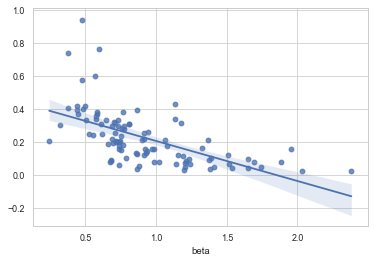

In [30]:
sns.regplot(data = scores, x= 'beta', y = scores['pos_eta'] + scores['neg_eta'])
sp.stats.pearsonr(beta, pos_eta+neg_eta)

In [91]:
for x in ['beta', 'pos_eta', 'neg_eta', 'risk ratio', 'q0']:
    for y in ['ius12', 'pswq', 'grq', 'gad7']:
        rval, pval = sp.stats.spearmanr(scores[x], scores[y])
        print(x, " , ", y, " :  R: ", rval, ",  p: ", pval)

beta  ,  ius12  :  R:  -0.07479539814326143 ,  p:  0.4595505156982095
beta  ,  pswq  :  R:  -0.10359817294583713 ,  p:  0.3050236323405704
beta  ,  grq  :  R:  -0.08838376323476219 ,  p:  0.3818794696984654
beta  ,  gad7  :  R:  -0.13875617257070522 ,  p:  0.1685782231027053
pos_eta  ,  ius12  :  R:  0.10846774801431194 ,  p:  0.282727023806892
pos_eta  ,  pswq  :  R:  0.04456739582897215 ,  p:  0.659727363591497
pos_eta  ,  grq  :  R:  -0.04880468618120607 ,  p:  0.6296650038182898
pos_eta  ,  gad7  :  R:  0.04090548572641133 ,  p:  0.6861529915980982
neg_eta  ,  ius12  :  R:  0.07922375678975753 ,  p:  0.43332781399337905
neg_eta  ,  pswq  :  R:  0.07103754588534415 ,  p:  0.4824719601903311
neg_eta  ,  grq  :  R:  -0.07613555322186905 ,  p:  0.4515237616592568
neg_eta  ,  gad7  :  R:  0.007285857216455968 ,  p:  0.9426468683786392
risk ratio  ,  ius12  :  R:  0.07135846307433907 ,  p:  0.48049090278993145
risk ratio  ,  pswq  :  R:  0.028878711475161464 ,  p:  0.775478790287023
risk

In [31]:
# No longer using this code
#pl.scatter(range(num_participants), scores['gad7'])
#pl.figure()
#pl.scatter(range(num_participants), scores['pswq'])
#pl.figure()
#pl.scatter(range(num_participants), scores['ius12'])
#pl.figure()
#pl.scatter(range(num_participants), scores['grq'])


In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
#LinearRegression().fit(scores['neg_eta'], scores['gad7'])

In [ ]:
sp.stats.linregress(scores['neg_eta'], scores['gad7'])
sp.stats.linregress(scores['pos_eta'], scores['gad7'])

In [ ]:
# not using 

#### Non - transformed parameter fits (stored in pfit) 

In [ ]:
from stantools.io import load_model

## Compile model.
StanModel = load_model('stan_real_q_opt')

pfit = [dict() for x in range(num_participants)] # model output parameters for each participant 

# run model fit for each participant 
for p in range(0, num_participants):
    

    if(p == 2 or p == 22 or p == 24 or p == 79 or p==93 or p == 4): 
        q_init = 5; 
        pt = 1; # TODO fix stan code
    else: 
        q_init = 5; 
        pt = 0;  
        
    ## Prepare data for Stan.
    dd = dict( T = trials_per_block, B = num_blocks, Y = choices[p,:], R = rewards[p,:],S = sure_values[p,:], p = pt, q = q_init)

    ## Fit model.
    s = 0; 

    StanFit = StanModel.optimizing(data=dd, seed=0, tol_param = 1e-3)
    
    for i in ['beta', 'pos_eta', 'neg_eta']:
        temp = StanFit[i]
        pfit[p][i] = temp[()]

In [ ]:
for p in range (0, num_participants):
    for b in range(0, num_blocks):
        Q = 5 #pfit_t[p]['q0']
        for t in range(0, trials_per_block):

            participant_i = (b*trials_per_block) + t; # overall trial number for current participant

            sure_points = sure_values[p, participant_i];
            reward = rewards[p, participant_i];
            y_true = choices[p, participant_i]; 

            theta_hat = inv_logit(Q - sure_points, pfit_t[p]['beta'])
            theta_hat_a[p, participant_i] = theta_hat; 

            y_hat[p, participant_i] = np.random.binomial(1, theta_hat)

            if(y_true == 1):
                y_pred[p, participant_i] = theta_hat;
            if(y_true == 0):
                y_pred[p, participant_i] = 1-theta_hat;

            delta = reward - Q; 
            if(delta < 0): Q += pfit_t[p]['neg_eta'] * delta 
            if(delta >= 0): Q += pfit_t[p]['pos_eta'] * delta 
                
y_hat_means = np.zeros(num_participants)
y_real_means = np.zeros(num_participants)
theta_hat_means = np.zeros(num_participants)

for i in range(0, num_participants): y_hat_means[i] = y_hat[i,:].mean()
for i in range(0, num_participants): y_real_means[i] = choices[i,:].mean()
for i in range(0, num_participants): theta_hat_means[i] = theta_hat_a[i,:].mean()

In [ ]:
for i in range(0, num_participants):
    beta[i] = pfit[i]['beta']
    pos_eta[i] = pfit[i]['pos_eta']
    neg_eta[i] = pfit[i]['neg_eta']
    risk_ratio[i] = (pos_eta[i] - neg_eta[i])/(pos_eta[i] + neg_eta[i])

sns.set_style("whitegrid")
sns.set_context("paper")

pl.ylim(0, 0.8)
pl.xlim(0, 0.8)

#sns.regplot(x= y_real_means, y = theta_hat_means, truncate = False, marker = '.', ci = 95)

sns.scatterplot(x= y_real_means, y = theta_hat_means, marker = '.')
line = {0:0, 0.1:0.1, 0.5: 0.5, 0.9:0.9}
pl.plot(list(line.keys()), list(line.values()))
pl.title("Posterior Predictive Check (theta hat means)")
pl.xlabel("% Times Participant Chose Risky Option")
pl.ylabel("Predicted % Risky Choice Option")
r = sp.stats.pearsonr(y_real_means, theta_hat_means)[0]
print("Pearson r: ", r)

greater = 0; 
for i in range(0, num_participants):
    if(theta_hat_means[i] > y_real_means[i]): greater+=1;
        
print("% Theta Hat greater than actual choices: ", greater/num_participants)

In [ ]:

pl.hist([pos_eta, neg_eta], color=['r','g'], label = ["Positive LR", "Negative LR"], alpha=0.9, bins=np.arange(0, 1, 0.1))
pl.legend()
pl.title("Distribution of Learning Rates")
pl.xlim(0, 1)
pl.xticks(np.arange(0, 1, 0.1))
pl.xlabel("Learning Rate (LR)")
pl.ylabel("Count (# participants)")

pl.figure()
sns.histplot(risk_ratio, bins = 10)
pl.title("Distribution of Risk Ratios")
pl.xlabel("Risk Ratio")
pl.ylabel("Count (# participants)")

In [ ]:
#### Tranformed parameters, fixed q0

In [ ]:
from stantools.io import load_model

## Compile model.
StanModel = load_model('t_stan_real_q_opt')

pfit_t = [dict() for x in range(num_participants)] # model output parameters for each participant 

# run model fit for each participant 
for p in range(0, num_participants):

    pt = 0
    q_init = 5
    
    ## Prepare data for Stan.
    dd = dict( T = trials_per_block, B = num_blocks, Y = choices[p,:], R = rewards[p,:],S = sure_values[p,:], p = pt, q = q_init, beta_sd = 1)

    ## Fit model.
    s = 44; 
    print(p)
    StanFit = StanModel.optimizing(data=dd, seed=s, tol_param = 1e-3)
    for i in ['beta', 'pos_eta', 'neg_eta']:
        temp = StanFit[i]
        pfit_t[p][i] = temp[()]

In [ ]:
# Beta distributed as transformed parameter 

from stantools.io import load_model

## Compile model.
StanModel = load_model('tq_stan_real')

pfit_t = [dict() for x in range(num_participants)] # model output parameters for each participant 

# run model fit for each participant 
for p in range(0, num_participants):
    pt = 0 # stan print debugging option

    ## Prepare data for Stan.
    dd = dict( T = trials_per_block, B = num_blocks, Y = choices[p,:], R = rewards[p,:],S = sure_values[p,:], p = pt, beta_scale = 3, beta_shift = 0, q0_scale = 10, q0_shift = 0)

    ## Fit model.
    s = 0; 
    #print(p)
    StanFit = StanModel.optimizing(data=dd, seed=s, tol_param = 1e-3)
    for i in ['beta', 'pos_eta', 'neg_eta', 'q0']:
        temp = StanFit[i]
        pfit_t[p][i] = temp[()]

##### Refit people with very low learning rates 

In [ ]:
for p in range(num_participants):
    
    refit = False; 
    if(pos_eta[p] < 0.01 or neg_eta[p] < 0.01 or pos_eta[p] > 0.99 or neg_eta[p] > 0.99): 
        print(p, " pos eta: ", pos_eta[p], " Neg eta: ", neg_eta[p], " Beta: ", beta[p])
        refit = True; 
        
    if(risk_ratio[p] > 0.99 or risk_ratio[p] < -0.99): 
        print(p, "RR: ", risk_ratio[p], " pos eta: ", pos_eta[p], " Neg eta: ", neg_eta[p]," Beta: ", beta[p])
        refit = True; 
    
        ## Refit model with new seed.
    if(refit): 
        StanModel = load_model('tq_stan_real')
        dd = dict( T = trials_per_block, B = num_blocks, Y = choices[p,:], R = rewards[p,:],S = sure_values[p,:], p = pt, beta_scale = 3, beta_shift = 0, q0_scale = 10, q0_shift = 0)
        newseed = 100; 
        StanFit = StanModel.optimizing(data=dd, seed=newseed, tol_param = 1e-3)
        for i in ['beta', 'pos_eta', 'neg_eta']:
            temp = StanFit[i]
            pfit_t[p][i] = temp[()]
            
for i in range(0, num_participants):
    beta[i] = pfit_t[i]['beta']
    pos_eta[i] = pfit_t[i]['pos_eta']
    neg_eta[i] = pfit_t[i]['neg_eta']
    risk_ratio[i] = (pos_eta[i] - neg_eta[i])/(pos_eta[i] + neg_eta[i])
    
print("----")
for p in range(num_participants):
    refit = False; 
    if(pos_eta[p] < 0.01 or neg_eta[p] < 0.01 or pos_eta[p] > 0.99 or neg_eta[p] > 0.99): 
        print(p, " pos eta: ", pos_eta[p], " Neg eta: ", neg_eta[p]," Beta: ", beta[p])
        refit = True; 
        
    if(risk_ratio[p] > 0.99 or risk_ratio[p] < -0.99): 
        print(p, "RR: ", risk_ratio[p], " pos eta: ", pos_eta[p], " Neg eta: ", neg_eta[p], " Beta: ", beta[p])
        refit = True; 
    
        ## Refit model with new seed.
    if(refit): 
        StanModel = load_model('tq_stan_real')
        dd = dict( T = trials_per_block, B = num_blocks, Y = choices[p,:], R = rewards[p,:],S = sure_values[p,:], p = pt, beta_scale = 3, beta_shift = 0, q0_scale = 10, q0_shift = 0)
        newseed = 300; 
        StanFit = StanModel.optimizing(data=dd, seed=newseed, tol_param = 1e-3)
        for i in ['beta', 'pos_eta', 'neg_eta']:
            temp = StanFit[i]
            pfit_t[p][i] = temp[()]

for i in range(0, num_participants):
    beta[i] = pfit_t[i]['beta']
    pos_eta[i] = pfit_t[i]['pos_eta']
    neg_eta[i] = pfit_t[i]['neg_eta']
    risk_ratio[i] = (pos_eta[i] - neg_eta[i])/(pos_eta[i] + neg_eta[i])
    
print("----")
for p in range(num_participants):
    refit = False; 
    if(pos_eta[p] < 0.01 or neg_eta[p] < 0.01 or pos_eta[p] > 0.99 or neg_eta[p] > 0.99): 
        print(p, " pos eta: ", pos_eta[p], " Neg eta: ", neg_eta[p], " Beta: ", beta[p])
        refit = True; 
        
    if(risk_ratio[p] > 0.99 or risk_ratio[p] < -0.99): 
        print(p, "RR: ", risk_ratio[p], " pos eta: ", pos_eta[p], " Neg eta: ", neg_eta[p], " Beta: ", beta[p])
        refit = True; 
        

In [ ]:
pl.scatter(range(num_blocks*trials_per_block), y_pred[0,:]);
pl.title("Y_pred values at each trial for Participant 0")
pl.figure()
pl.hist(y_pred[0, :], bins = 5)

pl.title("Distribution of Y_pred values for Participant 0");

In [ ]:
# No longer using this code 
#pl.scatter(x= y_real_means, y = y_hat_means)
#pl.ylim(0, 0.8)
#pl.xlim(0, 0.8)
#line = {0:0, 0.1:0.1, 0.5: 0.5, 0.9:0.9}
#pl.plot(list(line.keys()), list(line.values()))
#----# 
#pl.scatter(x= y_real_means, y = theta_hat_means)
#pl.ylim(0, 0.8)
#pl.xlim(0, 0.8)
#line = {0:0, 0.1:0.1, 0.5: 0.5, 0.9:0.9}
#pl.plot(list(line.keys()), list(line.values()))
#for i in range(num_participants): 
    #if(y_real_means[i] == theta_hat_means[i]): print(y_real_means[i], " ", theta_hat_means[i])
#---# 
#pl.figure()
#pl.scatter(range(0, num_participants), beta)
#print("beta mean:", beta.mean(), "min, max: ", beta.min(), " , ", beta.max())
#pl.figure()
#pl.scatter(range(0, num_participants), pos_eta)
#print("pos eta mean: ", pos_eta.mean(), pos_eta.min(), " , ", pos_eta.max())
#pl.figure()
#pl.scatter(range(0, num_participants), neg_eta)
#print("neg eta mean: ", neg_eta.mean(), neg_eta.min(), " , ", neg_eta.max())
#pl.figure()
#pl.scatter(range(0, num_participants), risk_ratio)
#print("risk ratio mean: ", risk_ratio.mean(), risk_ratio.min(), " , ", risk_ratio.max())

#pl.figure()
#sns.boxplot(risk_ratio)